<a href="https://colab.research.google.com/github/LilySu/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/LS_DS_241_Hyperparameter_Optimization_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Using a good validation set can prevent this. 
#You can check if your validation set is any good by seeing if your model 
#has similar scores on it to compared with on the Kaggle test set.

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Hyperparameter Optimization

Today we'll use this process:

## "A universal workflow of machine learning"

_Excerpt from Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning_
 
**1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

**2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

**3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

**4. Develop a first model that does better than a basic baseline:** a model with statistical power.

**5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

**6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

**Iterate on feature engineering: add new features, or remove features that don’t seem to be informative.** 

Once you’ve developed a satisfactory model configuration, you can **train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.**


## 1. Define the problem at hand and the data on which you'll train

We'll apply the workflow to a [project from _Python Data Science Handbook_](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic) by Jake VanderPlas:

> **Predicting Bicycle Traffic**

> As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

> We will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.

> Let's start by loading the two datasets, indexing by date:

So this is a regression problem, not a classification problem. We'll define the target, choose an evaluation metric, and choose models that are appropriate for regression problems.




### Download data

In [2]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1616k    0 1616k    0     0  1057k      0 --:--:--  0:00:01 --:--:-- 1057k


In [3]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-05-24 14:56:43--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv’

BicycleWeather.csv  100%[===================>] 229.44K  --.-KB/s    in 0.07s   

2019-05-24 14:56:44 (3.43 MB/s) - ‘BicycleWeather.csv’ saved [234945/234945]



### Load data

In [0]:
# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

import pandas as pd

# Download and join data into a dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

In [5]:
daily.head().T

,2012-10-04 00:00:00,2012-10-05 00:00:00,2012-10-06 00:00:00,2012-10-07 00:00:00,2012-10-08 00:00:00
Total,3475.0,3148.0,2006.0,2142.0,3537.0
PRCP,0.0,0.0,0.0,0.0,0.0
SNOW,0.0,0.0,0.0,0.0,0.0
SNWD,0.0,0.0,0.0,0.0,0.0
TMAX,189.0,217.0,239.0,239.0,211.0
TMIN,83.0,89.0,78.0,78.0,78.0
AWND,65.0,57.0,51.0,13.0,19.0
Total_yesterday,3521.0,3475.0,3148.0,2006.0,2142.0


In [0]:
#choose evaluation metric, and models

### First fast look at the data
- What's the shape?
- What's the date range?
- What's the target and the features?

In [7]:
daily.shape

(1063, 8)

In [8]:
daily.tail()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2015-08-28,2653.0,5,0,0,233,156,26,4336.0
2015-08-29,699.0,325,0,0,222,133,58,2653.0
2015-08-30,1213.0,102,0,0,200,128,47,699.0
2015-08-31,2823.0,0,0,0,189,161,58,1213.0
2015-09-01,2876.0,58,0,0,194,139,-9999,2823.0


In [9]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1063 entries, 2012-10-04 to 2015-09-01
Data columns (total 8 columns):
Total              1063 non-null float64
PRCP               1063 non-null int64
SNOW               1063 non-null int64
SNWD               1063 non-null int64
TMAX               1063 non-null int64
TMIN               1063 non-null int64
AWND               1063 non-null int64
Total_yesterday    1063 non-null float64
dtypes: float64(2), int64(6)
memory usage: 74.7 KB


Target
- Total : Daily total number of bicycle trips across Seattle's Fremont Bridge

Features
- Date (index) : from 2012-10-04 to 2015-09-01 in index
- Total_yesterday : Total trips yesterday
- PRCP : Precipitation (1/10 mm)
- SNOW : Snowfall (1/10 mm)
- SNWD : Snow depth (1/10 mm)
- TMAX : Maximum temperature (1/10 Celsius)
- TMIN : Minimum temperature (1/10 Celsius)
- AWND : Average daily wind speed (1/10 meters per second)

2. Choose how you’ll measure success on your problem.

Which metrics will you monitor on your validation data?

This is a regression problem, so we need to choose a regression [metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).



I'll choose mean absolute error.



In [0]:
from sklearn.metrics import mean_absolute_error
#regression problem, we choose regression metric
#on average, how many bike passengers pass the tremont bridge

In [0]:
#we want hyperparameter optimization.
#these last 100 days, we'll hold those out, with slice notation

In [12]:
#out of time test
train = daily[:-100]#everything but the last 100 days
test = daily[-100:]#last 100 days
train.shape, test.shape

((963, 8), (100, 8))

In [0]:
#to predict the future, we can rewind time to 100 days ago
#then predict for past 100 days with the next 100 days
# it is a more difficult test than a random set, worse test scores, but maybe more realistic

In [14]:
X_train = train.drop(columns='Total')
y_train = train['Total']

X_test = test.drop(columns='Total')
y_test = test['Total']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((963, 7), (963,), (100, 7), (100,))

3. Determine your evaluation protocol 

We're doing model selection, hyperparameter optimization, and performance estimation. So generally we have two ideal [options](https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg) to choose from:

- 3-way holdout method (train/validation/test split)
- Cross-validation with independent test set

I'll choose cross-validation with independent test set. Scikit-learn makes cross-validation convenient for us!

Specifically, I will use random shuffled cross validation to train and validate, but I will hold out an "out-of-time" test set, from the last 100 days of data:





In [0]:
# TODO

4. Develop a first model that does better than a basic baseline

### Look at the target's distribution and descriptive stats

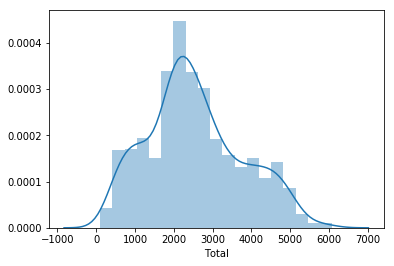

In [16]:
# TODO
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);
#if gives negative number, poisson and other models

In [0]:
#if this were to have an extremem right skew, we might do a log linear 
#poisson if I want it to be positive

In [18]:
y_train.describe()

count     963.000000
mean     2534.329180
std      1224.065027
min        98.000000
25%      1755.000000
50%      2381.000000
75%      3317.500000
max      6088.000000
Name: Total, dtype: float64

### Basic baseline 1

In [19]:
y_pred = [y_train.median()] * len(y_train)# a variety of baselines work
mean_absolute_error(y_train, y_pred)
#if I always predicted the median number of bicyclists per day, then I would be off 972 days

971.9376947040498

### Basic baseline 2

In [20]:
X_train.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,0,0,189,83,65,3521.0
2012-10-05,0,0,0,217,89,57,3475.0
2012-10-06,0,0,0,239,78,51,3148.0
2012-10-07,0,0,0,239,78,13,2006.0
2012-10-08,0,0,0,211,78,19,2142.0


In [21]:
y_train.head()

2012-10-04    3475.0
2012-10-05    3148.0
2012-10-06    2006.0
2012-10-07    2142.0
2012-10-08    3537.0
Name: Total, dtype: float64

In [22]:
y_pred = X_train['Total_yesterday']#we're going to predict if today is the same as yesterday
mean_absolute_error(y_train,y_pred)#we're going to be off this many days

708.061266874351

### First model that does better than a basic baseline

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate# returns dictionary on test scores in test set
#estimator itself
#scoring is none on default
#return dictionary of validation scores on test and train scores

In [0]:
#neg_mean_absolute_error doesn't maximize, like other scikitlearn functions
#regularly mean absolute error would return a smaller number, 
#but by taking a negative mean absolute error, we can flip it for a bigger number

In [0]:
scores = cross_validate(LinearRegression(), X_train, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 3,#higher numbers may have more variance, could be 5 or 7, computational time increases
                        return_train_score = True, return_estimator = True)#we return training scores as well as test score. We can put the dictionary this outputs into a dataframe

In [26]:
pd.DataFrame(scores)
#-mean absolute error optimizing for scikitlearn 
#most scikit learn scores tries to maximize scores, when taking the negative, then the lower the mean absolute error fits, lower
#Neg_mean_abs_error optimizes for closer to zero. where 0= good.

,fit_time,score_time,estimator,test_score,train_score
0,0.030067,0.001734,"LinearRegression(copy_X=True, fit_intercept=Tr...",-555.186275,-619.509206
1,0.003715,0.001307,"LinearRegression(copy_X=True, fit_intercept=Tr...",-651.126513,-583.427702
2,0.002944,0.001214,"LinearRegression(copy_X=True, fit_intercept=Tr...",-615.965800,-589.341301


In [0]:
#We see above that for 3-fold validation, each time we get a different test score from training score

In [28]:
-scores['test_score'].mean()#like multiplying by negative one 
#we're off by 600 bicyclists per day

607.4261958631806

In [29]:
scores['estimator'][0]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
type(scores['estimator'][0])#so I can get out the intercept and coefficents from this model

sklearn.linear_model.base.LinearRegression

In [31]:
scores['estimator'][0].coef_

array([ -3.52510306,  -0.08202866, -12.04502742,   9.4752378 ,
        -4.6077746 ,  -2.74519066,   0.41736022])

In [32]:
scores['estimator'][0].intercept_

566.7766337283679

In [33]:
for i, model in enumerate(scores['estimator']):#loop over scores dictionary
  #enumerate iterates if I want the thing itself and also some index number
  #for each score, we have an linear regression model and i, an integer
  coefficients = model.coef_
  intercept = model.intercept_
  feature_names = X_train.columns
  #get their intercept
  #get their column name
  
  print(f'Model form cross-validation fold #{i}')
  print('Intercept', intercept)
  print(pd.Series(coefficients, feature_names).to_string())
  print('\n')
  #we split training data into a, b and c
  #fold #0: train a and b and tested on c, what are intercepts and coefficients
  #fold #1: train a and c
  #fold #2: train b and c
  

Model form cross-validation fold #0
Intercept 566.7766337283679
PRCP               -3.525103
SNOW               -0.082029
SNWD              -12.045027
TMAX                9.475238
TMIN               -4.607775
AWND               -2.745191
Total_yesterday     0.417360


Model form cross-validation fold #1
Intercept 671.9064515706045
PRCP               -2.772253
SNOW               -0.000995
SNWD               20.800688
TMAX                8.804948
TMIN               -3.741386
AWND               -6.108300
Total_yesterday     0.405074


Model form cross-validation fold #2
Intercept 465.84525362296563
PRCP               -2.876196
SNOW               -0.016432
SNWD               -8.809696
TMAX               10.419441
TMIN               -5.862868
AWND               -2.398991
Total_yesterday     0.423493




In [0]:
#analogous to stats models at the 95% confidence interval - having a high p value for this coef so we do not reject the null hypothesis
#that the coefficient's value might be zero, we're not sure if it is positive or negative

In [0]:
#univariate linear regression
# linear regression plus other models should be better, at 607 a day compared to other scores

In [0]:
#with no additional features, no feature engineering done
#It's like saying we have X_train['Total_yesterday'] as the feature, where intercept is zero
#and coefficient of 1, so 1 multiplied by ['Total_yesterday'] + 0, which is nothing,
#So a model that uses this useless feature plus another feature should outperform it

## 5. Develop a model that overfits. 

"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —Chollet

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

Diagram Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

### Random Forest?

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [0]:
#With a more complex model, your training score should keep improving
#Yet your validation score could decrease with model complexity until it gets overfit

In [0]:
#Your training score should provide a ceiling for your validation score

In [39]:
# Random Forest Regressor - this is a regressor problem
from sklearn. ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1)#Instantiating Random Forest Regressor Object
#this model should pick up non-linear, non-monotonic and interactions between features. 
#With these features this is the best that can be done without feature engineering and hyperparameter tuning

scores = cross_validate(model, X_train, y_train,#doing cross validation with random forest
                        scoring='neg_mean_absolute_error',
                        cv=3, return_train_score=True,
                        return_estimator=True)
pd.DataFrame(scores)
#random forest not performing as well as linear regression

,fit_time,score_time,estimator,test_score,train_score
0,0.219840,0.010069,"(DecisionTreeRegressor(criterion='mse', max_de...",-556.361963,-241.256963
1,0.223354,0.010139,"(DecisionTreeRegressor(criterion='mse', max_de...",-646.182399,-222.050327
2,0.217767,0.011117,"(DecisionTreeRegressor(criterion='mse', max_de...",-636.941651,-227.856153


In [40]:
-scores['test_score'].mean()

613.1620041536864

In [41]:
# TODO
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=50)

scores = cross_validate(model, X_train, y_train,
                        scoring='neg_mean_absolute_error',
                        cv=3, return_train_score=True,
                        return_estimator=True)
pd.DataFrame(scores)
#random forest not performing as well as linear regression

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,fit_time,score_time,estimator,test_score,train_score
0,0.258080,0.002476,"XGBRegressor(base_score=0.5, booster='gbtree',...",-544.872138,-523.867542
1,0.025489,0.002414,"XGBRegressor(base_score=0.5, booster='gbtree',...",-639.600249,-489.142993
2,0.025455,0.002299,"XGBRegressor(base_score=0.5, booster='gbtree',...",-633.515497,-480.231481


In [42]:
-scores['test_score'].mean()

605.9959611585701

### Validation Curve

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html

> Validation curve. Determine training and test scores for varying parameter values. This is similar to grid search with one parameter.

In [43]:
-scores['test_score'].mean()

605.9959611585701

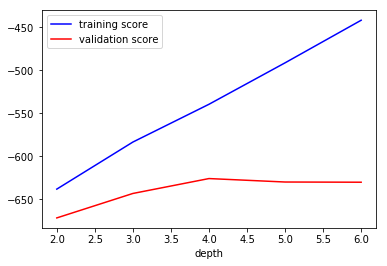

In [44]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve#allows for any given model a variety of parameter values

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]#try a variety of parameters for model
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');
#like training with max-depth 2, train with 3, 4 etc

In [0]:
#It is possible and recommended to search the hyperparameter space for the best cross validation score
#GridSearchCV will exhaustively consider all parameter combinations
#RandomizedSearchCV can sample a given number of subjects

### `RandomizedSearchCV`

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html

In [46]:
# recommended to search with highest validation score, gridsearch will exhaustively consider all parameters
#Gridsearch may take a long time, to get an incrementally better score
# RandomizedSearch CV can sample a given number of candidates
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {#What is the distribution of values that we'll try
     'n_estimators': [100, 200],#Do exactly one hundred or two hundred
     'max_depth': [4, 5],
     'criterion': ['mse', 'mae']#Mean Squared Error, Mean Absolute Error, we try both and see what does the best.
}#I can try different options for my pipeline
#in real world, you will have more parameter values

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),#parameters, what are the estimators we are using
    param_distributions=param_distributions,
    n_iter = 8,#if that took too long, can try like 4, tradeoff of runtime to optimization of solution
    #We have 2 n_estimators, multiply by 2 max depth, multiplied by criterion - 8 will exhaustively use all which will equal GridSearchCV
    #grid search would take too long, Randomized Search is faster
    #at 8 iterations, this equals grid search
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,#operate where it's at, because it might take too long
    return_train_score=True
)

gridsearch.fit(X_train, y_train)
#n_iter trades off runtime vs quality of solution
#criterion measure quality of split using mean squared error or mean absolute error, not going to make a huge difference 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_estimators=100, max_depth=4, criterion=mse ....................
[CV]  n_estimators=100, max_depth=4, criterion=mse, score=(train=-574.472, test=-557.174), total=   0.1s
[CV] n_estimators=100, max_depth=4, criterion=mse ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, criterion=mse, score=(train=-530.248, test=-642.450), total=   0.1s
[CV] n_estimators=100, max_depth=4, criterion=mse ....................
[CV]  n_estimators=100, max_depth=4, criterion=mse, score=(train=-538.577, test=-629.072), total=   0.1s
[CV] n_estimators=200, max_depth=4, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, criterion=mse, score=(train=-572.253, test=-555.635), total=   0.2s
[CV] n_estimators=200, max_depth=4, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, criterion=mse, score=(train=-529.626, test=-640.866), total=   0.2s
[CV] n_estimators=200, max_depth=4, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, criterion=mse, score=(train=-536.655, test=-625.854), total=   0.2s
[CV] n_estimators=100, max_depth=5, criterion=mse ....................
[CV]  n_estimators=100, max_depth=5, criterion=mse, score=(train=-526.882, test=-546.995), total=   0.1s
[CV] n_estimators=100, max_depth=5, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, criterion=mse, score=(train=-490.560, test=-639.081), total=   0.1s
[CV] n_estimators=100, max_depth=5, criterion=mse ....................
[CV]  n_estimators=100, max_depth=5, criterion=mse, score=(train=-492.253, test=-629.838), total=   0.1s
[CV] n_estimators=200, max_depth=5, criterion=mse ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=200, max_depth=5, criterion=mse, score=(train=-524.163, test=-545.774), total=   0.3s
[CV] n_estimators=200, max_depth=5, criterion=mse ....................
[CV]  n_estimators=200, max_depth=5, criterion=mse, score=(train=-490.204, test=-637.307), total=   0.3s
[CV] n_estimators=200, max_depth=5, criterion=mse ....................
[CV]  n_estimators=200, max_depth=5, criterion=mse, score=(train=-490.472, test=-627.617), total=   0.3s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................
[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-554.611, test=-545.554), total=   0.7s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................
[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-515.604, test=-635.479), total=   0.7s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................
[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-525.162, test=-609.899), total=   0.6s
[CV] n_estimato

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   15.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=42,

In [47]:
gridsearch.cv_results_

{'mean_fit_time': array([0.116551  , 0.22920903, 0.12828557, 0.25599813, 0.65637207,
        1.32135288, 0.7406865 , 1.45469753]),
 'mean_score_time': array([0.00641394, 0.01089835, 0.00676219, 0.01144775, 0.00671895,
        0.01170913, 0.00676529, 0.01157951]),
 'mean_test_score': array([-609.56563333, -607.45161258, -605.30455589, -603.56609775,
        -596.97695742, -597.13798027, -595.28737799, -594.11456386]),
 'mean_train_score': array([-547.76556914, -546.17783635, -503.23167945, -501.61335502,
        -531.79222741, -531.57189642, -492.88619678, -492.43870067]),
 'param_criterion': masked_array(data=['mse', 'mse', 'mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4, 4, 5, 5, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'p

In [48]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from search of  {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)#spits out 8 rows
#randomized search cv, we have to look at parameters

Best result from search of  8 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,1.454698,0.021401,0.01158,0.000115,200,5,mae,"{'n_estimators': 200, 'max_depth': 5, 'criteri...",-537.343224,-633.188069,-611.812399,-594.114564,41.080965,1,-514.399139,-476.132208,-486.784755,-492.438701,16.125856


In [59]:
-gridsearch.best_score_

594.1145638629284

In [49]:
type(gridsearch.best_estimator_)

sklearn.ensemble.forest.RandomForestRegressor

In [50]:
gridsearch.best_estimator_
# gridsearch.best_estimator_.predict_proba

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
#It's important to develop a model that overfits, otherwise it is not working
#Deep learning is less feature engineering, more architecture

In [0]:
#deep learning can memorize noise, so if you are not able to overfit, something is wrong
#in deep learning there is more emphasis on regularization and tuning of hyperparameters

In [0]:
#get to the basic baseline first, then emphasize feature engineering

 FEATURE ENGINEERING!

Jake VanderPlas demonstrates this feature engineering: 
https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
He has some awesome examples

In [0]:
import numpy as np
from datetime import date, datetime, timedelta
# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']#manual one hot encoding
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)
    X['IsWeekday'] = X['Mon']+X['Tue']+X['Wed']+X['Thu']+X['Fri'] == 1#--------------------Is Weekday?

    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
#     from pandas.tseries.holiday import USFederalHolidayCalendar
#     cal = USFederalHolidayCalendar()
#     holidays = cal.holidays('2012', '2016')
#     X = X.join(pd.Series(1, index=holidays, name='holiday'))
#     X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
      

#     DOY = X.index.values
#     DOY = pd.to_datetime(DOY)
#     Y = DOY.year
#     M = DOY.month
#     D = DOY.date

#     Winter = X.loc[datetime.date(year=Y,month=12,day=21):datetime.date(year=Y,month=3,day=19)]
#     X['IsWinter'] = DOY in Winter
    X['Month'] = X.index.month
    X['Day'] = X.index.day
    
    X['IsWinter'] = ((X['Month'] == 3) & (X['Day'] < 21)) & ((X['Month'] == 12) & (X['Day'] >= 21)) & (X['Month'] <= 2) #--------------------Is from 12/22 - 3/21?
    X['NearPopRidership'] = (X['Month'] == 5) & (abs(X['Day'] - 14) < 5)


    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))

    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMINear13'] = abs(X['TMIN'] - 13) < 3#--------------------Is below 45F?
    X['TMAX'] /= 10
    X['TMAXNear28'] = abs(X['TMAX'] - 28) < 3#--------------------Is above 90F?
    X['daylight_hrsNear15'] = abs(X['daylight_hrs'] - 15) < 3
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])

    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254
    X['PrecipitationAboveHalfin'] = X['PRCP'] > 0.5#--------------------Is above .5 in? 

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)#binary flag of whether a day is dry or not
    
    #wind speed is in 1/10 meters per second, convert to miles per hour
    X['AWND'] *= .2237
    X['WindAbove8mph'] = X['AWND'] > 8


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.
    
    X['AvgPast6DayCount'] = (X['Total_yesterday'].shift(1) + X['Total_yesterday'].shift(2) + X['Total_yesterday'].shift(3) + X['Total_yesterday'].shift(4) + X['Total_yesterday'].shift(5) + X['Total_yesterday'].shift(6))/6#--------------------Avg 3 Past Day Count
    X['AvgPast6DayTempMin'] = (X['TMIN'].shift(1) + X['TMIN'].shift(2) + X['TMIN'].shift(3) + X['TMIN'].shift(4) + X['TMIN'].shift(5) + X['TMIN'].shift(6))/6#--------------------Avg Past 3 Day Temp
    X['AvgPast6DayTempMax'] = (X['TMAX'].shift(1) + X['TMAX'].shift(2) + X['TMAX'].shift(3) + X['TMIN'].shift(4) + X['TMIN'].shift(5) + X['TMIN'].shift(6))/6#--------------------Avg Past 3 Day Temp
    
    NewDFNearestTmax = X.iloc[(X['TMAX']-1).abs().argsort()[:20]]    
    X['Avg3PastDayMAXTemp'] = NewDFNearestTmax['TMAX'].mean()#--------------------Nearest Temperature Max
    X['Avg3PastDayMAXCount'] = NewDFNearestTmax['AvgPast6DayCount'].mean()#--------------------Nearest Temperature Max
    
    NewDFNearestTmax = X.iloc[(X['TMIN']-1).abs().argsort()[:20]]    
    X['Avg3PastDayMINTemp'] = NewDFNearestTmax['TMIN'].mean()#--------------------Nearest Temperature Max
    X['Avg3PastDayMINCount'] = NewDFNearestTmax['AvgPast6DayCount'].mean()#--------------------Nearest Temperature Max
    
#     X.index - timedelta(2)
    
#     X['AvgLast3Days'] = X.iloc['Total_yesterday',['GetDayBeforeYesName']]

    return X

X_train = jake_wrangle(X_train)

In [61]:
X_train.tail(10).T

,2015-05-15 00:00:00,2015-05-16 00:00:00,2015-05-17 00:00:00,2015-05-18 00:00:00,2015-05-19 00:00:00,2015-05-20 00:00:00,2015-05-21 00:00:00,2015-05-22 00:00:00,2015-05-23 00:00:00,2015-05-24 00:00:00
PRCP,0,0,0,0,0,0,0,0,0,0
SNOW,0,0,0,0,0,0,0,0,0,0
SNWD,0,0,0,0,0,0,0,0,0,0
TMAX,20,15.6,19.4,25.6,21.7,23.3,25.6,16.7,16.1,17.8
TMIN,9.4,11.1,10.6,12.2,11.7,10.6,11.7,11.7,11.7,11.1
AWND,6.2636,6.711,4.6977,6.711,5.8162,4.0266,4.6977,8.2769,5.8162,6.0399
Total_yesterday,3811,5053,1655,2011,4845,4872,4580,4768,3668,1580
Mon,0,0,0,1,0,0,0,0,0,0
Tue,0,0,0,0,1,0,0,0,0,0
Wed,0,0,0,0,0,1,0,0,0,0


In [62]:
# X_train['Total_yesterday'].max
maxval = X_train.loc[X_train['Total_yesterday'].idxmax()]
maxval.to_frame()
# df.loc[df['Value'].idxmax()]

,2014-05-14 00:00:00
PRCP,0
SNOW,0
SNWD,0
TMAX,27.8
TMIN,13.3
AWND,7.3821
Total_yesterday,6088
Mon,0
Tue,0
Wed,1


In [63]:
# X_train.nlargest(3, X_train.Total_yesterday)
X_train.apply(lambda s: s.abs()).max().nlargest(3)

SNOW                9999.0
Total_yesterday     6088.0
AvgPast6DayCount    5137.5
dtype: float64

In [64]:
X_train.sort_values(by = 'Total_yesterday', ascending = False)[:10]


,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,IsWeekday,Month,Day,IsWinter,NearPopRidership,daylight_hrs,TMINear13,TMAXNear28,daylight_hrsNear15,Temp (C),PrecipitationAboveHalfin,dry day,WindAbove8mph,annual,AvgPast6DayCount,AvgPast6DayTempMin,AvgPast6DayTempMax,Avg3PastDayMAXTemp,Avg3PastDayMAXCount,Avg3PastDayMINTemp,Avg3PastDayMINCount
2014-05-14,0.00000,0,0,27.8,13.3,7.3821,6088.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True,5,14,False,True,14.848126,True,True,True,20.55,False,1,False,1.608219,3542.333333,9.050000,15.633333,2.24,1486.125,1.05,1876.8
2014-05-02,0.00000,0,0,18.3,10.6,10.5139,5937.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,5,2,False,False,14.279617,True,False,True,14.45,False,1,True,1.575342,3395.500000,7.666667,16.383333,2.24,1486.125,1.05,1876.8
2014-05-15,0.00000,0,0,26.7,12.8,6.7110,5887.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,5,15,False,True,14.891306,True,True,True,19.75,False,1,False,1.610959,3647.833333,9.700000,16.933333,2.24,1486.125,1.05,1876.8
2014-05-17,0.00000,0,0,20.0,11.7,7.1584,5742.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,5,17,False,True,14.975401,True,False,True,15.85,False,1,False,1.616438,4468.000000,11.383333,17.500000,2.24,1486.125,1.05,1876.8
2014-05-21,0.00000,0,0,20.0,10.6,3.8029,5678.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True,5,21,False,False,15.133898,True,False,True,15.30,False,1,False,1.627397,4268.166667,11.133333,16.583333,2.24,1486.125,1.05,1876.8
2014-08-27,0.00000,0,0,28.9,16.1,3.5792,5551.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True,8,27,False,False,13.460724,False,True,True,22.50,False,1,False,1.895890,3696.666667,13.600000,20.550000,2.24,1486.125,1.05,1876.8
2014-05-08,0.53937,0,0,13.9,9.4,7.6058,5455.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,5,8,False,False,14.574602,False,False,True,11.65,True,0,False,1.591781,3376.500000,8.883333,13.166667,2.24,1486.125,1.05,1876.8
2014-05-13,0.00000,0,0,26.7,12.8,8.5006,5432.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,True,5,13,False,True,14.804222,True,True,True,19.75,False,1,True,1.605479,3409.666667,8.116667,13.783333,2.24,1486.125,1.05,1876.8
2014-05-16,0.00000,0,0,20.0,11.7,9.1717,5300.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,5,16,False,True,14.933738,True,False,True,15.85,False,1,True,1.613699,4090.666667,10.633333,17.683333,2.24,1486.125,1.05,1876.8
2014-07-30,0.00000,0,0,29.4,14.4,7.6058,5248.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True,7,30,False,False,14.880580,True,True,True,21.90,False,1,False,1.819178,3199.333333,13.983333,21.200000,2.24,1486.125,1.05,1876.8


In [65]:
X_train.dtypes

PRCP                        float64
SNOW                          int64
SNWD                          int64
TMAX                        float64
TMIN                        float64
AWND                        float64
Total_yesterday             float64
Mon                         float64
Tue                         float64
Wed                         float64
Thu                         float64
Fri                         float64
Sat                         float64
Sun                         float64
IsWeekday                      bool
Month                         int64
Day                           int64
IsWinter                       bool
NearPopRidership               bool
daylight_hrs                float64
TMINear13                      bool
TMAXNear28                     bool
daylight_hrsNear15             bool
Temp (C)                    float64
PrecipitationAboveHalfin       bool
dry day                       int64
WindAbove8mph                  bool
annual                      

In [66]:
X_train.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Month,Day,daylight_hrs,Temp (C),dry day,annual,AvgPast6DayCount,AvgPast6DayTempMin,AvgPast6DayTempMax,Avg3PastDayMAXTemp,Avg3PastDayMAXCount,Avg3PastDayMINTemp,Avg3PastDayMINCount
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,957.000000,957.000000,957.000000,9.630000e+02,963.000,9.630000e+02,9.630000e+02
mean,0.123576,-41.390447,0.109034,15.673209,7.830737,7.133544,2536.141225,0.142264,0.142264,0.142264,0.143302,0.143302,0.143302,0.143302,6.402908,15.669782,11.677381,11.751973,0.554517,1.317808,2530.738419,7.816475,11.727830,2.240000e+00,1486.125,1.050000e+00,1.876800e+03
std,0.264611,643.435674,2.700110,6.994807,4.914016,3.275810,1224.232861,0.349502,0.349502,0.349502,0.350563,0.350563,0.350563,0.350563,3.631073,8.747378,2.568741,5.756242,0.497277,0.762023,894.949686,4.571007,5.498708,2.665920e-15,0.000,1.866144e-14,3.071140e-11
min,0.000000,-9999.000000,0.000000,-1.600000,-7.100000,0.894800,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,8.218894,-3.800000,0.000000,0.000000,599.833333,-4.983333,-1.333333,2.240000e+00,1486.125,1.050000e+00,1.876800e+03
25%,0.000000,0.000000,0.000000,10.600000,4.400000,4.921400,1755.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,9.206870,7.750000,0.000000,0.658904,1837.333333,4.533333,7.516667,2.240000e+00,1486.125,1.050000e+00,1.876800e+03
50%,0.000000,0.000000,0.000000,14.400000,7.800000,6.487300,2381.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,16.000000,11.364878,10.850000,1.000000,1.317808,2371.000000,7.316667,10.833333,2.240000e+00,1486.125,1.050000e+00,1.876800e+03
75%,0.129921,0.000000,0.000000,20.600000,11.700000,9.171700,3325.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,23.000000,14.118901,16.375000,1.000000,1.976712,3311.833333,11.366667,16.300000,2.240000e+00,1486.125,1.050000e+00,1.876800e+03
max,2.200787,74.000000,80.000000,35.600000,18.300000,21.251500,6088.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,31.000000,15.781095,26.700000,1.000000,2.635616,5137.500000,17.033333,24.166667,2.240000e+00,1486.125,1.050000e+00,1.876800e+03


In [67]:
X_train_num = X_train.select_dtypes(include=['float64', 'int64'])
Riderbymonth = X_train_num.groupby('Month')['Total_yesterday'].mean()
Riderbymonth

Month
1     1762.698925
2     1836.869048
3     2145.290323
4     2646.600000
5     3640.476744
6     3499.016667
7     3826.354839
8     3578.774194
9     2942.966667
10    2553.677778
11    1890.888889
12    1372.483871
Name: Total_yesterday, dtype: float64

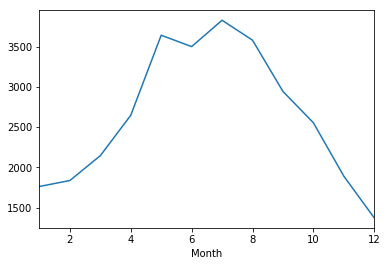

In [68]:
Riderbymonth.plot()

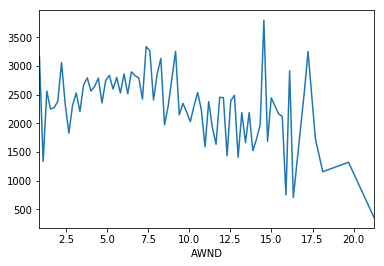

In [69]:
windbymonth = X_train_num.groupby('AWND')['Total_yesterday'].mean()
windbymonth.plot()

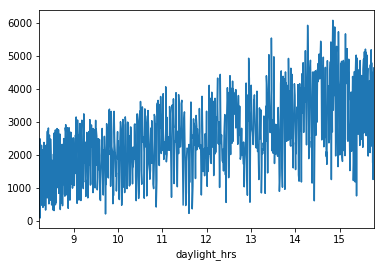

In [70]:
lightbymonth = X_train_num.groupby('daylight_hrs')['Total_yesterday'].mean()
lightbymonth.plot()


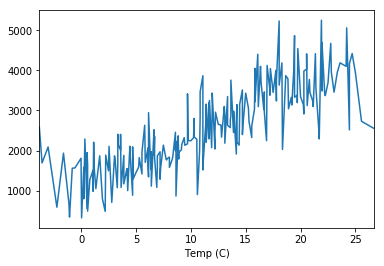

In [71]:
Tbymonth = X_train_num.groupby('Temp (C)')['Total_yesterday'].mean()
Tbymonth.plot()

In [0]:
# sns.pairplot(X_train)

In [74]:
grouped = X_train.groupby(["Month"])
grouped['Total_yesterday'].agg(np.mean)
# x=pd.DataFrame(X_train.reset_index()).T
# for i in x.columns:
#     df1row = pd.DataFrame(x.nlargest(3, i).index.tolist(), index=['top1','top2','top3']).T
#     rslt = pd.concat([rslt, df1row], axis=0)

# print(rslt)

Month
1     1762.698925
2     1836.869048
3     2145.290323
4     2646.600000
5     3640.476744
6     3499.016667
7     3826.354839
8     3578.774194
9     2942.966667
10    2553.677778
11    1890.888889
12    1372.483871
Name: Total_yesterday, dtype: float64

In [75]:
# X_train.apply(X_train['Total_yesterday']).sort_values()
X_train.loc[X_train['Total_yesterday'].idxmax()]
# X_train.groupby("Total_yesterday").apply(lambda X_train:X_train.Total_yesterday(X_train.value.argmax()))

PRCP                              0
SNOW                              0
SNWD                              0
TMAX                           27.8
TMIN                           13.3
AWND                         7.3821
Total_yesterday                6088
Mon                               0
Tue                               0
Wed                               1
Thu                               0
Fri                               0
Sat                               0
Sun                               0
IsWeekday                      True
Month                             5
Day                              14
IsWinter                      False
NearPopRidership               True
daylight_hrs                14.8481
TMINear13                      True
TMAXNear28                     True
daylight_hrsNear15             True
Temp (C)                      20.55
PrecipitationAboveHalfin      False
dry day                           1
WindAbove8mph                 False
annual                      

In [0]:
X_train = X_train.fillna(X_train.mean())

In [0]:
# X_train = X_train.dropna()

In [0]:
# import datetime 
# DOY = X_train.index.values
# DOY = pd.to_datetime(DOY)
# Y = DOY.year
# X_train.loc[datetime.date(year=Y,month=12,day=21):datetime.date(year=Y,month=3,day=19)]

In [79]:
NewDFNearestTmax = X_train.iloc[(X_train['TMAX']-1).abs().argsort()[:3]]
NewDFNearestTmax['TMAX'].mean()

1.1

In [0]:
# X_train['d'] = X_train.index.values

In [0]:
# import datetime 
# DOY = X_train.index.values
# DOY = pd.to_datetime(DOY)
# Y = DOY.year
# X_train[(X_train['d']>datetime.date(Y,1,1)) & (X_train['d']<datetime.date(Y,3,1))] 

In [0]:
X_train['year'] = X_train.index.year

In [0]:
X_train['month'] = X_train.index.month

In [84]:
X_train.head(3)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,IsWeekday,Month,Day,IsWinter,NearPopRidership,daylight_hrs,TMINear13,TMAXNear28,daylight_hrsNear15,Temp (C),PrecipitationAboveHalfin,dry day,WindAbove8mph,annual,AvgPast6DayCount,AvgPast6DayTempMin,AvgPast6DayTempMax,Avg3PastDayMAXTemp,Avg3PastDayMAXCount,Avg3PastDayMINTemp,Avg3PastDayMINCount,year,month
2012-10-04,0.0,0,0,18.9,8.3,14.5405,3521.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,10,4,False,False,11.219142,False,False,False,13.60,False,1,True,0.000000,2530.738419,7.816475,11.72783,2.24,1486.125,1.05,1876.8,2012,10
2012-10-05,0.0,0,0,21.7,8.9,12.7509,3475.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,10,5,False,False,11.161038,False,False,False,15.30,False,1,True,0.002740,2530.738419,7.816475,11.72783,2.24,1486.125,1.05,1876.8,2012,10
2012-10-06,0.0,0,0,23.9,7.8,11.4087,3148.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,10,6,False,False,11.103056,False,False,False,15.85,False,1,True,0.005479,2530.738419,7.816475,11.72783,2.24,1486.125,1.05,1876.8,2012,10


In [0]:
# pd.cut(orders_with_hour_of_day['order_hour_of_day'],bins=24)

In [86]:
X_train.index - timedelta(1)

DatetimeIndex(['2012-10-03', '2012-10-04', '2012-10-05', '2012-10-06',
               '2012-10-07', '2012-10-08', '2012-10-09', '2012-10-10',
               '2012-10-11', '2012-10-12',
               ...
               '2015-05-14', '2015-05-15', '2015-05-16', '2015-05-17',
               '2015-05-18', '2015-05-19', '2015-05-20', '2015-05-21',
               '2015-05-22', '2015-05-23'],
              dtype='datetime64[ns]', length=963, freq='D')

In [87]:
type(X_train.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
# springsol = 

# test = X_train[X_train.index.to_pydatetime() < datetime.datetime(2015,3,21)]
# test

In [0]:
# X_train.index.values.strftime("%Y")

In [0]:
# uniqueyear = X_train.index.year.unique()
# for eachyear in uniqueyear:
#   fo
#   test = X_train[X_train.index.to_pydatetime() < datetime.datetime(i,3,21)]


In [90]:
test.shape

(100, 8)

In [0]:
# X_train['r'] = X_train[X_train.index.to_pydatetime() < datetime.datetime(2015,1,1)]

In [0]:
X_train['r'] = X_train.index.month < 3 
X_train['r'] = X_train.index.month > 12

In [0]:
# s = X_train.index.values
# X_tr = s.pd.to_datetime()


In [0]:
# |X_train.head(1)

In [0]:

# X_train = pd.Timestamp.now()
# X_train.to_pydatetime()
# X_train.year

In [0]:
# import calendar
# import datetime
# X_train['AdjustedDateToEndOfMonth'] = X_train['d'].map(
#     lambda x: datetime.datetime(
#         x.year,
#         x.month,
#         max(calendar.monthcalendar(x.year, x.month)[-1][:5])
#     )
# )

In [0]:
# X_train['nn'] = pd.DatetimeIndex(X_train).year
# X_train.head()

In [0]:
# X_train['t'] = X_train.index.values in New


Linear Regression (with new features)

In [98]:
scores = cross_validate(LinearRegression(),X_train, y_train,
                        scoring='neg_mean_absolute_error', cv=3,
                        return_train_score=True, return_estimator=True)
pd.DataFrame(scores)
#with feature engineering, we cut the error in half
#a good prediction usually involves feature engineering and a complex model type

,fit_time,score_time,estimator,test_score,train_score
0,0.022198,0.003195,"LinearRegression(copy_X=True, fit_intercept=Tr...",-306.997664,-298.169003
1,0.010715,0.004131,"LinearRegression(copy_X=True, fit_intercept=Tr...",-309.396466,-291.528889
2,0.011392,0.004527,"LinearRegression(copy_X=True, fit_intercept=Tr...",-328.323988,-282.728972


In [99]:
-scores['test_score'].mean()

314.9060390706127

In [113]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100)


param_distributions = {
    'n_estimators': [100,125,150],#iterable
    'max_depth' : [4,5],
    'criterion' : ['mae']
}

#My X_train has changed with different features

gridsearch2 = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter = 100,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True
)

gridsearch2.fit(X_train, y_train)


pd.DataFrame(scores)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=100, max_depth=4, criterion=mae ....................
[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-111.759, test=-250.997), total=   0.2s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................
[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-112.012, test=-322.679), total=   0.2s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................
[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-117.788, test=-284.882), total=   0.2s
[CV] n_estimators=125, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=125, max_depth=4, criterion=mae, score=(train=-97.520, test=-252.134), total=   0.2s
[CV] n_estimators=125, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=125, max_depth=4, criterion=mae, score=(train=-99.776, test=-322.058), total=   0.2s
[CV] n_estimators=125, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=125, max_depth=4, criterion=mae, score=(train=-101.337, test=-281.657), total=   0.2s
[CV] n_estimators=150, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=150, max_depth=4, criterion=mae, score=(train=-86.075, test=-257.440), total=   0.2s
[CV] n_estimators=150, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=150, max_depth=4, criterion=mae, score=(train=-88.506, test=-322.166), total=   0.2s
[CV] n_estimators=150, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=150, max_depth=4, criterion=mae, score=(train=-89.782, test=-281.982), total=   0.2s
[CV] n_estimators=100, max_depth=5, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=100, max_depth=5, criterion=mae, score=(train=-68.216, test=-273.183), total=   0.2s
[CV] n_estimators=100, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=100, max_depth=5, criterion=mae, score=(train=-63.580, test=-321.434), total=   0.2s
[CV] n_estimators=100, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=100, max_depth=5, criterion=mae, score=(train=-70.700, test=-292.589), total=   0.2s
[CV] n_estimators=125, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=125, max_depth=5, criterion=mae, score=(train=-58.196, test=-274.453), total=   0.3s
[CV] n_estimators=125, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=125, max_depth=5, criterion=mae, score=(train=-51.532, test=-321.647), total=   0.3s
[CV] n_estimators=125, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=125, max_depth=5, criterion=mae, score=(train=-59.153, test=-292.177), total=   0.2s
[CV] n_estimators=150, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=150, max_depth=5, criterion=mae, score=(train=-49.724, test=-275.140), total=   0.3s
[CV] n_estimators=150, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=150, max_depth=5, criterion=mae, score=(train=-42.622, test=-321.917), total=   0.3s
[CV] n_estimators=150, max_depth=5, criterion=mae ....................


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=150, max_depth=5, criterion=mae, score=(train=-49.124, test=-292.240), total=   0.3s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.3s finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,fit_time,score_time,estimator,test_score,train_score
0,0.022198,0.003195,"LinearRegression(copy_X=True, fit_intercept=Tr...",-306.997664,-298.169003
1,0.010715,0.004131,"LinearRegression(copy_X=True, fit_intercept=Tr...",-309.396466,-291.528889
2,0.011392,0.004527,"LinearRegression(copy_X=True, fit_intercept=Tr...",-328.323988,-282.728972


In [114]:
-gridsearch2.best_score_

285.28302399664034

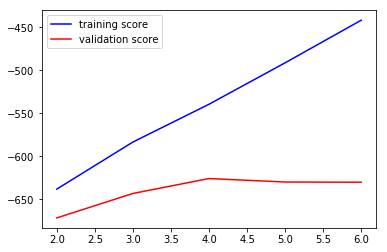

In [101]:
plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')

In [102]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.022198,0.003195,"LinearRegression(copy_X=True, fit_intercept=Tr...",-306.997664,-298.169003
1,0.010715,0.004131,"LinearRegression(copy_X=True, fit_intercept=Tr...",-309.396466,-291.528889
2,0.011392,0.004527,"LinearRegression(copy_X=True, fit_intercept=Tr...",-328.323988,-282.728972


### Random Forest (with new features)

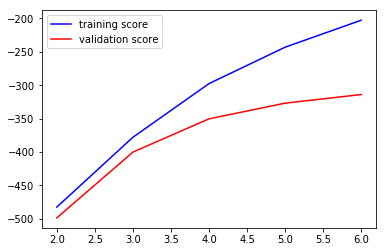

In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=200)

depth = [2, 3, 4, 5, 6]#try a range of values for these parameters
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')

In [104]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.022198,0.003195,"LinearRegression(copy_X=True, fit_intercept=Tr...",-306.997664,-298.169003
1,0.010715,0.004131,"LinearRegression(copy_X=True, fit_intercept=Tr...",-309.396466,-291.528889
2,0.011392,0.004527,"LinearRegression(copy_X=True, fit_intercept=Tr...",-328.323988,-282.728972


In [105]:
param_distributions = {
    'n_estimators': [50,100],#iterable
    'max_depth' : [4,5],
    'criterion' : ['mae']
}

#My X_train has changed with different features

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter = 10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True
)

gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=50, max_depth=4, criterion=mae .....................
[CV]  n_estimators=50, max_depth=4, criterion=mae, score=(train=-319.783, test=-365.585), total=   1.1s
[CV] n_estimators=50, max_depth=4, criterion=mae .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=50, max_depth=4, criterion=mae, score=(train=-282.317, test=-401.774), total=   1.1s
[CV] n_estimators=50, max_depth=4, criterion=mae .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV]  n_estimators=50, max_depth=4, criterion=mae, score=(train=-311.063, test=-351.072), total=   1.1s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-315.063, test=-359.684), total=   2.2s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-280.405, test=-401.879), total=   2.2s
[CV] n_estimators=100, max_depth=4, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, criterion=mae, score=(train=-309.633, test=-349.289), total=   2.3s
[CV] n_estimators=50, max_depth=5, criterion=mae .....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.1s remaining:    0.0s


[CV]  n_estimators=50, max_depth=5, criterion=mae, score=(train=-262.427, test=-347.895), total=   1.3s
[CV] n_estimators=50, max_depth=5, criterion=mae .....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.3s remaining:    0.0s


[CV]  n_estimators=50, max_depth=5, criterion=mae, score=(train=-234.557, test=-368.680), total=   1.2s
[CV] n_estimators=50, max_depth=5, criterion=mae .....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.6s remaining:    0.0s


[CV]  n_estimators=50, max_depth=5, criterion=mae, score=(train=-257.870, test=-326.391), total=   1.3s
[CV] n_estimators=100, max_depth=5, criterion=mae ....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.9s remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, criterion=mae, score=(train=-257.761, test=-340.228), total=   2.6s
[CV] n_estimators=100, max_depth=5, criterion=mae ....................
[CV]  n_estimators=100, max_depth=5, criterion=mae, score=(train=-232.560, test=-367.689), total=   2.5s
[CV] n_estimators=100, max_depth=5, criterion=mae ....................
[CV]  n_estimators=100, max_depth=5, criterion=mae, score=(train=-255.248, test=-321.294), total=   2.6s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   21.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=42,

In [106]:
pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.105411,0.015294,0.005009,0.000181,50,4,mae,"{'n_estimators': 50, 'max_depth': 4, 'criterio...",-365.585452,-401.774486,-351.072492,-372.810810,21.320216,4,-319.783037,-282.316822,-311.063489,-304.387783,16.007355
1,2.221776,0.042858,0.007226,0.000070,100,4,mae,"{'n_estimators': 100, 'max_depth': 4, 'criteri...",-359.684112,-401.878614,-349.288879,-370.283868,22.740363,3,-315.062889,-280.404821,-309.633442,-301.700384,15.220501
2,1.252183,0.014280,0.005282,0.000334,50,5,mae,"{'n_estimators': 50, 'max_depth': 5, 'criterio...",-347.895202,-368.680405,-326.391121,-347.655576,17.265359,2,-262.427165,-234.556682,-257.869766,-251.617871,12.206708
3,2.542829,0.017243,0.007487,0.000082,100,5,mae,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",-340.228349,-367.688925,-321.294237,-343.070504,19.046875,1,-257.761386,-232.560078,-255.247648,-248.523037,11.334072


In [107]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.022198,0.003195,"LinearRegression(copy_X=True, fit_intercept=Tr...",-306.997664,-298.169003
1,0.010715,0.004131,"LinearRegression(copy_X=True, fit_intercept=Tr...",-309.396466,-291.528889
2,0.011392,0.004527,"LinearRegression(copy_X=True, fit_intercept=Tr...",-328.323988,-282.728972


In [0]:
# importances = pd.Series(search.best_estimator_.feature_importances_,X_train.columns)
# plt.figure(figsize=(5,10))
# importances.sort_values().plot.barh(color='grey');

In [110]:
-gridsearch.best_score_

343.07050363447553


### Feature engineering, explained by Francois Chollet

> _Feature engineering_ is the process of using your own knowledge about the data and about the machine learning algorithm at hand to make the algorithm work better by applying hardcoded (nonlearned) transformations to the data before it goes into the model. In many cases, it isn’t reasonable to expect a machine-learning model to be able to learn from completely arbitrary data. The data needs to be presented to the model in a way that will make the model’s job easier.

> Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of day.

> If you choose to use the raw pixels of the image as input data, then you have a difficult machine-learning problem on your hands. You’ll need a convolutional neural network to solve it, and you’ll have to expend quite a bit of computational resources to train the network.

> But if you already understand the problem at a high level (you understand how humans read time on a clock face), then you can come up with much better input features for a machine-learning algorithm: for instance, write a Python script to follow the black pixels of the clock hands and output the (x, y) coordinates of the tip of each hand. Then a simple machine-learning algorithm can learn to associate these coordinates with the appropriate time of day.

> You can go even further: do a coordinate change, and express the (x, y) coordinates as polar coordinates with regard to the center of the image. Your input will become the angle theta of each clock hand. At this point, your features are making the problem so easy that no machine learning is required; a simple rounding operation and dictionary lookup are enough to recover the approximate time of day.

> That’s the essence of feature engineering: making a problem easier by expressing it in a simpler way. It usually requires understanding the problem in depth.

> Before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on.

> Neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:

> - Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
> - Good features let you solve a problem with far less data. The ability of deep-learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, then the information value in their features becomes critical.


In [0]:
#encoded values ie 999, -999

#best_estimator = .predict

ASSIGNMENT

**1.** Complete the notebook cells that were originally commented **`TODO`**. 

**2.** Then, focus on feature engineering to improve your cross validation scores. Collaborate with your cohort on Slack. You could start with the ideas [Jake VanderPlas suggests:](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic)

> Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

**3.** Experiment with the Categorical Encoding notebook.

**4.** At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

### STRETCH

**A.** Apply this lesson other datasets you've worked with, like Ames Housing, Bank Marketing, or others.

**B.** In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.

**C.** _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?